### REFERENCES 

Ahamed, S. (2018) Text classification using CNN, LSTM and visualize word embeddings: Part-2, Medium. Available at: https://sabber.medium.com/classifying-yelp-review-comments-using-cnn-lstm-and-visualize-word-embeddings-part-2-ca137a42a97d (Accessed: 17 September 2023). 

@article{joulin2016bag,
  title={Bag of Tricks for Efficient Text Classification},
  author={Joulin, Armand and Grave, Edouard and Bojanowski, Piotr and Mikolov, Tomas},
  journal={arXiv preprint arXiv:1607.01759},
  year={2016}
}


www.youtube.com. (n.d.). Text Classification using LSTM on Amazon Review Dataset with TensorFlow 2.1 #nlp #tutorial. [online] Available at: https://www.youtube.com/watch?v=DUZn8hMLnbI [Accessed 17 Sep. 2023].

‌Analytics Vidhya. (2021). LSTM for Text Classification | Beginners Guide to Text Classification. [online] Available at: https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/.








### Data Preparation

0


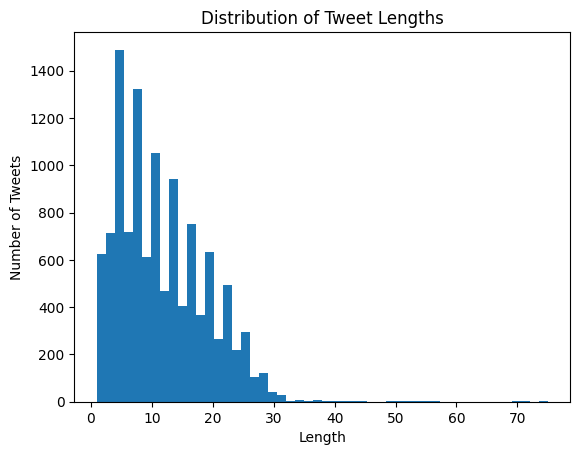

Average length: 11.622237392268964
Median length: 10.0
90th percentile length: 22.0


In [2]:
import pandas as pd
import gensim
import matplotlib.pyplot as plt


data = pd.read_csv('UseThisClean.csv')

# Convert labels to numerical categories if they aren't already
data['Class'] = data['Class'].astype('category').cat.codes

data = data.dropna(subset=['clean_text'])
print(data['clean_text'].isnull().sum())

# Calculate lengths
tweet_lengths = data['clean_text'].apply(lambda x: len(str(x).split()))

# Plot histogram
plt.hist(tweet_lengths, bins=50)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Tweets')
plt.show()

# Print some statistics
print("Average length:", tweet_lengths.mean())
print("Median length:", tweet_lengths.median())
print("90th percentile length:", tweet_lengths.quantile(0.90))


 Loading FastText Embeddings

In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec


--2023-09-01 21:49:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.15, 52.84.251.27, 52.84.251.114, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610017300 (1.5G) [binary/octet-stream]
Saving to: ‘wiki.ar.vec’

wiki.ar.vec         100%[===================>]   1.50G  24.5MB/s    in 69s     

2023-09-01 21:50:36 (22.3 MB/s) - ‘wiki.ar.vec’ saved [1610017300/1610017300]



In [4]:
from gensim.models import KeyedVectors

# Loading the FastText model
fasttext_model = KeyedVectors.load_word2vec_format('wiki.ar.vec')

embedding_dim = fasttext_model.vector_size


Data Tokenization and Embedding Matrix Creation

In [6]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 10000  # Only consider top 10k words
max_len = 30  # Only consider the first 30 words of each tweet (Calculated average words of each tweet in previous cell)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['clean_text'])

sequences = tokenizer.texts_to_sequences(data['clean_text'])
word_index = tokenizer.word_index

# Pad sequences
X = pad_sequences(sequences, maxlen=max_len)
y = data['Class'].values

# Splitting data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        if word in fasttext_model:
            embedding_matrix[i] = fasttext_model[word]

Model Architecture + Training


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 30, 300)           3000000   
                                                                 
 lstm_12 (LSTM)              (None, 128)               219648    
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_12 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                     

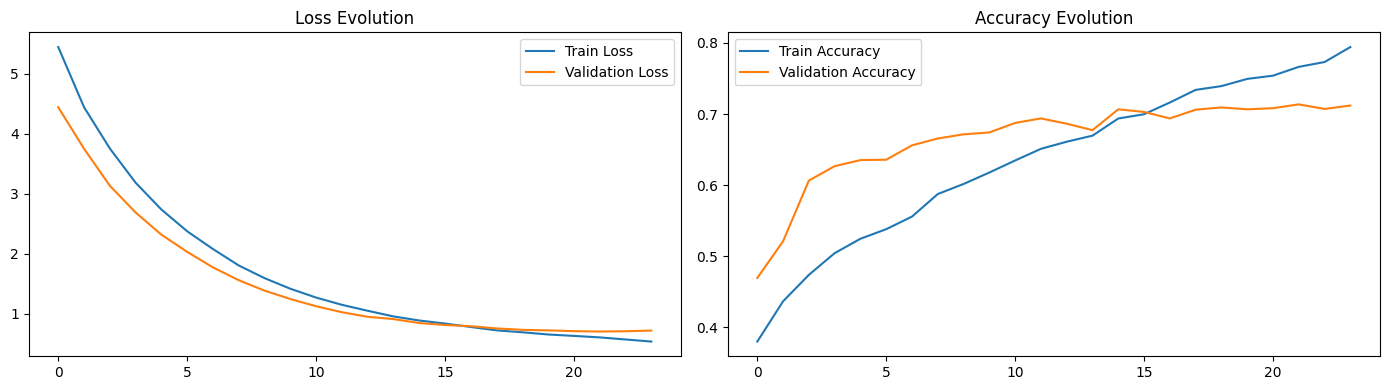

In [30]:
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Constants
vocab_size = 10000  # Consider top 10k words

model = Sequential()

# Embedding layer
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Single LSTM layer with dropout only on the input (to leverage cuDNN acceleration)
model.add(LSTM(128, dropout=0.5))

# Add dropout after LSTM to compensate for removed recurrent dropout
model.add(Dropout(0.5))

# Dense layer with L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Final layer
model.add(Dense(3, activation='softmax'))

# Adam optimizer with modified initial learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)



# Model summary
model.summary()

# Model training
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stop, reduce_lr, checkpoint])

# Load the best model for evaluation
best_model = load_model('best_model.h5')

# Visualization of training process
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

Evaluation

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('best_model.h5')

# Predict using the best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


74/74 [==============================] - 1s 3ms/step
Accuracy: 0.700938566552901
Precision: 0.7033653846153847
Recall: 0.705043100604876
F1 Score: 0.7035684178526199
